## Notebook to answer question c: Who won each of the individual awards

In [37]:
# Load datasets
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

players_teams = pd.read_csv("project_data/players_teams.csv")
awards = pd.read_csv("project_data/awards_players.csv")
players = pd.read_csv("project_data/players_clean.csv")

### Attribute correlation players_teams table

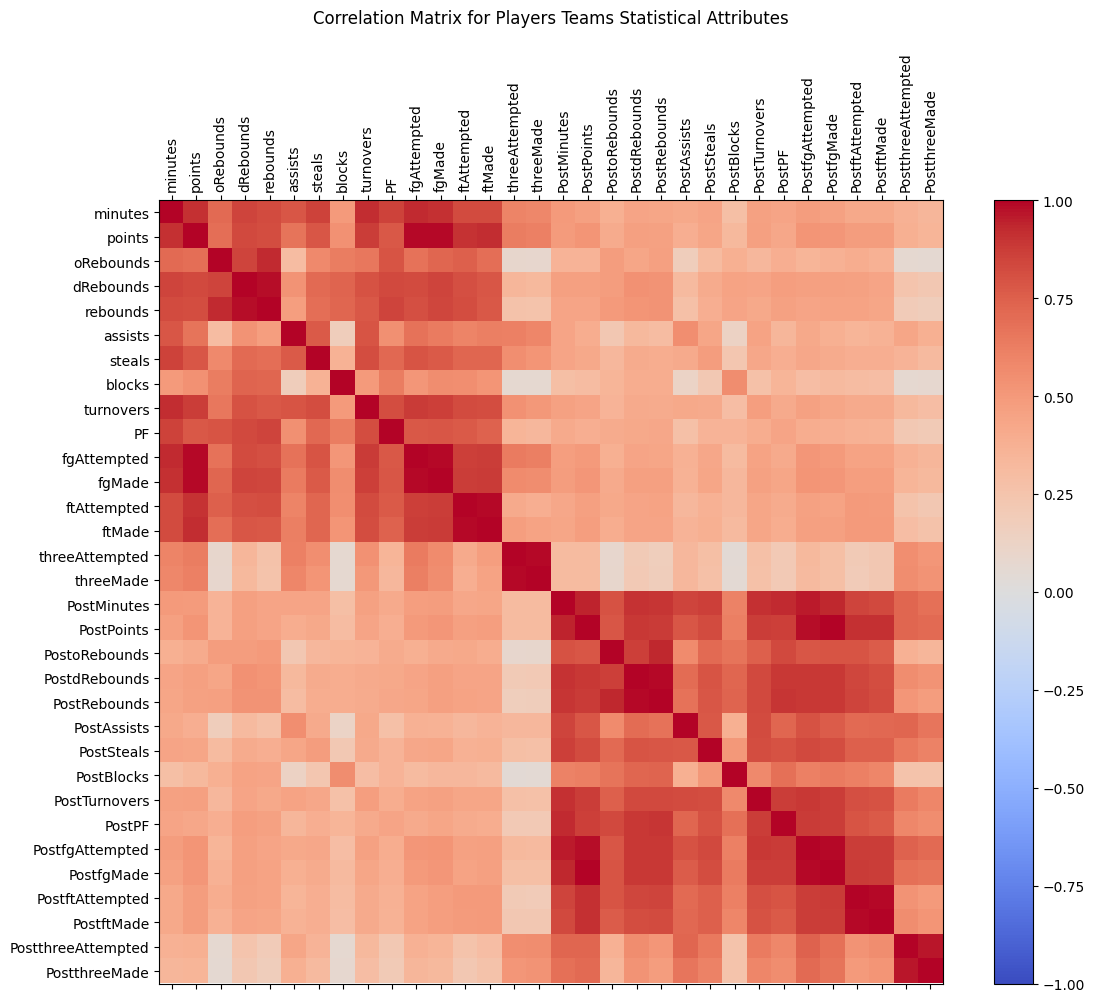

Correlation matrix includes 32 statistical attributes


In [38]:
# Since we use the players_teams dataset to calculate awards given each year and predict, we should check how each attribute correlates with others

# Select only numeric columns that represent basketball statistics (exclude IDs and categorical columns)
numeric_cols = players_teams.select_dtypes(include=[np.number]).columns.tolist()
# Remove non-statistical columns like year and stint
cols_to_exclude = ['year', 'stint', 'GP', 'GS', 'dq', 'PostGP', 'PostGS', 'PostDQ']
stats_cols = [col for col in numeric_cols if col not in cols_to_exclude]

corr = players_teams[stats_cols].corr()
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(stats_cols), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(stats_cols, rotation=90)
ax.set_yticklabels(stats_cols)
plt.title('Correlation Matrix for Players Teams Statistical Attributes', pad=20)
plt.tight_layout()
plt.show()

print(f"Correlation matrix includes {len(stats_cols)} statistical attributes")


### Feature Selection for Prediction Models

Based on the correlation matrix above, we need to reduce the number of features to avoid multicollinearity and overfitting. We'll:
1. Identify highly correlated features (redundant information)
2. Create composite/engineered features (efficiency metrics)
3. Select the most important features for prediction

In [39]:
# Step 1: Identify highly correlated features (>0.85 correlation)
# These features provide redundant information

def find_high_correlation_pairs(corr_matrix, threshold=0.85):
    """Find pairs of features with correlation above threshold"""
    high_corr_pairs = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append({
                    'feature1': corr_matrix.columns[i],
                    'feature2': corr_matrix.columns[j],
                    'correlation': corr_matrix.iloc[i, j]
                })
    
    return pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False)

"""
high_corr = find_high_correlation_pairs(corr, threshold=0.85)
print("Highly correlated feature pairs (>0.85):")
print(high_corr.to_string())
print(f"\nTotal pairs: {len(high_corr)}")
"""

def find_high_correlation_many(corr_matrix, threshold=0.85):
    """ Find sets of features that are all highly correlated with each other """
    visited = set()
    high_corr_sets = []

    for i in range(len(corr_matrix.columns)):
        if corr_matrix.columns[i] in visited:
            continue
        current_set = {corr_matrix.columns[i]}
        for j in range(len(corr_matrix.columns)):
            if i != j and abs(corr_matrix.iloc[i, j]) > threshold:
                current_set.add(corr_matrix.columns[j])
                visited.add(corr_matrix.columns[j])
        if len(current_set) > 1:
            high_corr_sets.append(current_set)
            visited.update(current_set)

    return high_corr_sets

high_corr_sets = find_high_correlation_many(corr, threshold=0.90)
print("\nSets of highly correlated features (>0.90):")
for s in high_corr_sets:
    print(s)
print(f"\nTotal sets: {len(high_corr_sets)}")

high_corr_sets2 = find_high_correlation_many(corr, threshold=0.85)
print("\nSets of highly correlated features (>0.85):")
for s in high_corr_sets2:
    print(s)
print(f"\nTotal sets: {len(high_corr_sets2)}")

high_corr_sets3 = find_high_correlation_many(corr, threshold=0.80)
print("\nSets of highly correlated features (>0.80):")
for s in high_corr_sets3:
    print(s)
print(f"\nTotal sets: {len(high_corr_sets3)}")



Sets of highly correlated features (>0.90):
{'turnovers', 'fgAttempted', 'points', 'minutes', 'fgMade'}
{'rebounds', 'oRebounds'}
{'rebounds', 'dRebounds'}
{'points', 'ftAttempted', 'ftMade'}
{'threeAttempted', 'threeMade'}
{'PostPoints', 'PostTurnovers', 'PostfgMade', 'PostfgAttempted', 'PostMinutes', 'PostPF'}
{'PostRebounds', 'PostoRebounds'}
{'PostRebounds', 'PostdRebounds'}
{'PostPoints', 'PostftMade', 'PostftAttempted'}
{'PostthreeMade', 'PostthreeAttempted'}

Total sets: 10

Sets of highly correlated features (>0.85):
{'turnovers', 'fgAttempted', 'fgMade', 'points', 'steals', 'PF', 'minutes'}
{'rebounds', 'oRebounds'}
{'rebounds', 'dRebounds'}
{'fgAttempted', 'ftAttempted', 'points', 'ftMade', 'fgMade'}
{'threeAttempted', 'threeMade'}
{'PostSteals', 'PostPoints', 'PostTurnovers', 'PostdRebounds', 'PostfgMade', 'PostfgAttempted', 'PostMinutes', 'PostRebounds', 'PostPF'}
{'PostRebounds', 'PostoRebounds', 'PostdRebounds'}
{'PostPoints', 'PostfgMade', 'PostfgAttempted', 'PostftAtte

### Creating new dataset with engineered features for awards

In [40]:
# Create a new DataFrame with selected + engineered features
players_teams_clean = pd.DataFrame({
    "playerID": players_teams["playerID"],
    "year": players_teams["year"],
    "team": players_teams["tmID"],

    # Per-minute efficiency stats
    "points_per_min": players_teams["points"] / players_teams["minutes"],
    "assists_per_min": players_teams["assists"] / players_teams["minutes"],
    "rebounds_per_min": players_teams["rebounds"] / players_teams["minutes"],
    "steals_per_min": players_teams["steals"] / players_teams["minutes"],
    "blocks_per_min": players_teams["blocks"] / players_teams["minutes"],
    "turnovers_per_min": players_teams["turnovers"] / players_teams["minutes"],

    # Shooting efficiencies
    "FG%": players_teams["fgMade"] / players_teams["fgAttempted"],
    "FT%": players_teams["ftMade"] / players_teams["ftAttempted"],
    "Three%": players_teams["threeMade"] / players_teams["threeAttempted"],

    # Play style
    "Three Rate": players_teams["threeAttempted"] / players_teams["fgAttempted"],  # share of shots from 3s
    #"assist_to_turnover": players_teams["assists"] / players_teams["turnovers"]
})

# Handle any divide-by-zero or NaN issues
players_teams_clean = players_teams_clean.replace([float('inf'), -float('inf')], pd.NA).fillna(0)

# Save dataframe
players_teams_clean.to_csv("project_data/awards_data/players_teams_clean.csv", index=False)

# Save or preview
print(players_teams_clean.head())

     playerID  year team  points_per_min  assists_per_min  rebounds_per_min  \
0  abrossv01w     2  MIN        0.405437         0.062648          0.205674   
1  abrossv01w     3  MIN        0.390062         0.074534          0.181366   
2  abrossv01w     4  MIN        0.401515         0.103535          0.178030   
3  abrossv01w     5  MIN        0.316017         0.097403          0.160173   
4  abrossv01w     6  MIN        0.391248         0.077220          0.137709   

   steals_per_min  blocks_per_min  turnovers_per_min       FG%       FT%  \
0        0.049645        0.010638           0.100473  0.389078  0.727273   
1        0.052174        0.012422           0.114286  0.376582  0.482759   
2        0.055556        0.013889           0.113636  0.392982  0.704082   
3        0.064935        0.004329           0.093074  0.352518  0.608696   
4        0.061776        0.007722           0.102960  0.394928  0.726027   

     Three%  Three Rate  
0  0.250000    0.259386  
1  0.333333    0

### Correlation Matrix for the newly created dataframe

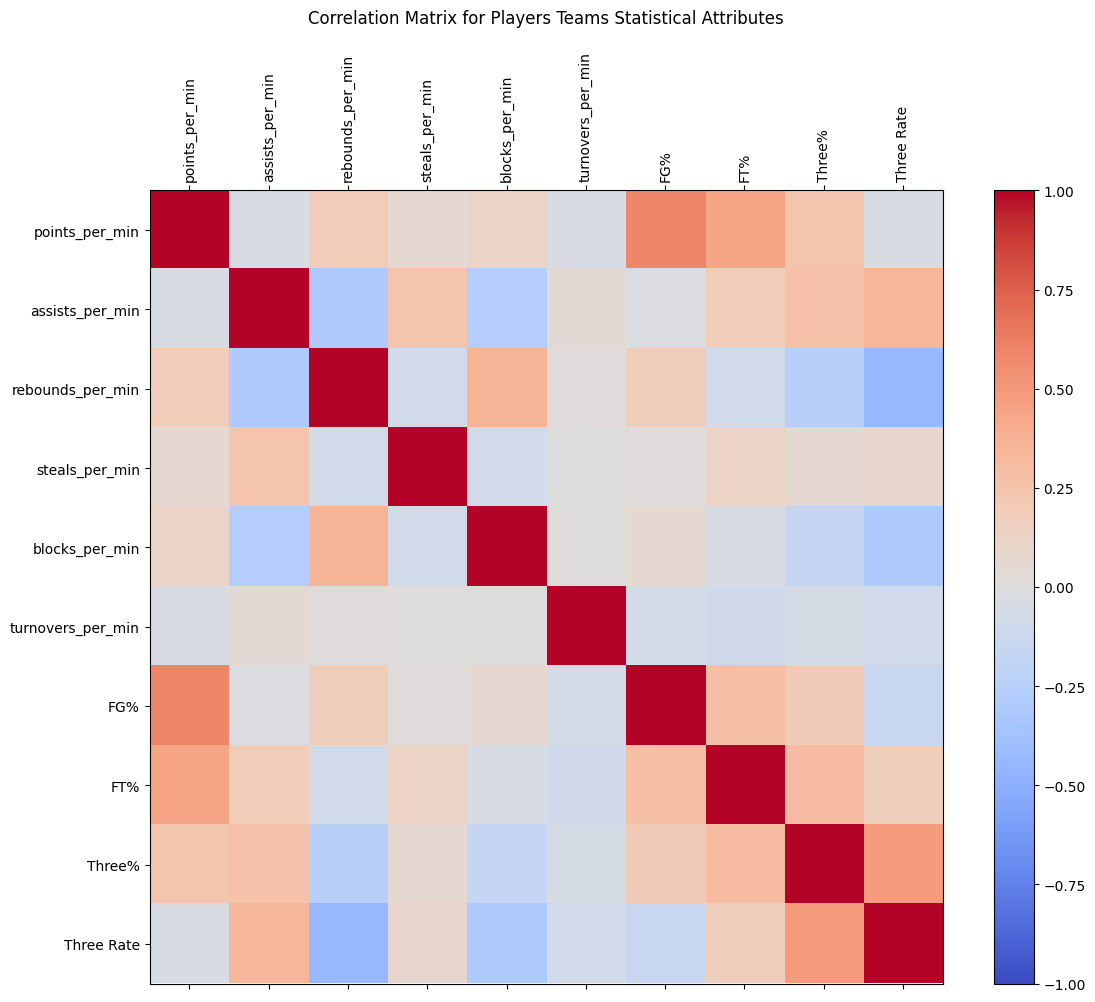

Correlation matrix includes 10 statistical attributes


In [41]:
# Find high corr sets of players_teams_clean

# Since we use the players_teams dataset to calculate awards given each year and predict, we should check how each attribute correlates with others

# Select only numeric columns that represent basketball statistics (exclude IDs and categorical columns)
numeric_cols = players_teams_clean.select_dtypes(include=[np.number]).columns.tolist()
# Remove non-statistical columns like year and stint
cols_to_exclude = ['year', 'stint', 'GP', 'GS', 'dq', 'PostGP', 'PostGS', 'PostDQ']
stats_cols = [col for col in numeric_cols if col not in cols_to_exclude]

corr = players_teams_clean[stats_cols].corr()
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(stats_cols), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(stats_cols, rotation=90)
ax.set_yticklabels(stats_cols)
plt.title('Correlation Matrix for Players Teams Statistical Attributes', pad=20)
plt.tight_layout()
plt.show()

print(f"Correlation matrix includes {len(stats_cols)} statistical attributes")


### 1. Rookie of the Year Award

In [42]:
# Function to identify rookies by year
def get_rookies_by_year(players_teams):
    players_teams = players_teams.sort_values(by=['year'])
    rookies_by_year = {}
    min_year = players_teams['year'].min()
    max_year = players_teams['year'].max()
    previous_years_players = set()

    for year in range(min_year + 1, max_year + 1):
        current_years = players_teams[players_teams['year'] == year]
        current_years_players = set(current_years['playerID'])

        rookies = current_years_players - previous_years_players
        rookies_by_year[year] = rookies

        previous_years_players.update(current_years_players)

    return rookies_by_year

rookies_by_year = get_rookies_by_year(players_teams)

for year, rookies in rookies_by_year.items():
    print(f"Year: {year}")
    print(f"Rookies: {rookies}")

Year: 2
Rookies: {'schumke01w', 'williwe01w', 'reidtr01w', 'darlihe01w', 'henniso01w', 'erbsu01w', 'milleke01w', 'mcwilta01w', 'smithch03w', 'dickeke01w', 'colleka01w', 'consuca01w', 'thomast01w', 'torniel01w', 'washito01w', 'feastal01w', 'brondsa01w', 'campbed01w', 'johnsti01w', 'jacksta01w', 'edwarmi01w', 'douglka01w', 'wynneda01w', 'badertr01w', 'streiju01w', 'radunha01w', 'pettibr01w', 'pavlimi01w', 'stafftr01w', 'phillta01w', 'marcimi01w', 'crawlsy01w', 'hallvi01w', 'milleco01w', 'hledeko01w', 'griffyo01w', 'nemcoev01w', 'weathte01w', 'scottol01w', 'williri01w', 'willina01w', 'machacl01w', 'brumfma01w', 'pagemu01w', 'boltoru01w', 'stockta01w', 'hollake01w', 'figgsuk01w', 'schwege01w', 'wolteka01w', 'mabikmw01w', 'dossaci01w', 'whitmta01w', 'torrele01w', 'nolande01w', 'brownru01w', 'blackde01w', 'alhalta01w', 'shakiel01w', 'penicti01w', 'fordst01w', 'stinsan01w', 'martima01w', 'williad01w', 'mapprh01w', 'frettla01w', 'tuvicsl01w', 'bristre01w', 'mcgheca01w', 'smithch02w', 'palmewe0

In [43]:
# Calculate Performance of Rookies in all years
# Performance Formula : ((Points + Rebounds + Assists + Steals + Blocks) - ((Field Goals Att. - Field Goals Made) + (Free Throws Att. - Free Throws Made) + Turnovers))

rookie_performance = {}

# Function to calculate performance for a single player in a given year
def calculate_player_yearly_performance(year, player_id):
    stats = players_teams[(players_teams['year'] == year) & (players_teams['playerID'] == player_id)]
    if stats.empty:
        return 0
    points = stats['points'].values[0]
    rebounds = stats['rebounds'].values[0]
    assists = stats['assists'].values[0]
    steals = stats['steals'].values[0]
    blocks = stats['blocks'].values[0]
    fg_att = stats['fgAttempted'].values[0]
    fg_made = stats['fgMade'].values[0]
    ft_att = stats['ftAttempted'].values[0]
    ft_made = stats['ftMade'].values[0]
    turnovers = stats['turnovers'].values[0]

    performance = (points + rebounds + assists + steals + blocks) - ((fg_att - fg_made) + (ft_att - ft_made) + turnovers)
    return performance

# Function to calculate performance for all rookies in a given year
def calculate_rookies_yearly_performance(year, players_teams):
    rookies = get_rookies_by_year(players_teams).get(year, [])
    for rookie in rookies:
        performance = calculate_player_yearly_performance(year, rookie)
        rookie_performance[(year, rookie)] = performance
    return rookie_performance

for year, rookies in rookies_by_year.items():
    rookie_performance = calculate_rookies_yearly_performance(year, players_teams)

# Display Rookie of the Year for each year
rookie_of_the_year = {}
for year, rookies in rookies_by_year.items():
    best_rookie = None
    best_performance = float('-inf')
    for rookie in rookies:
        performance = rookie_performance.get((year, rookie), 0)
        if performance > best_performance:
            best_performance = performance
            best_rookie = rookie
    rookie_of_the_year[year] = (best_rookie, best_performance)

# Compare with actual awards data
print("\nComparison with Actual Awards Data:")
actual_awards = awards[awards['award'] == 'Rookie of the Year']
actual_awards = actual_awards[['year', 'playerID']]
actual_awards_dict = dict(zip(actual_awards['year'], actual_awards['playerID']))
for year, (predicted_rookie, _) in rookie_of_the_year.items():
    actual_rookie = actual_awards_dict.get(year)

    if actual_rookie == predicted_rookie:
        print(f"Year: {year}, Predicted: {predicted_rookie}, Result: ✅ Correct")
    else:
        actual_perf = rookie_performance.get((year, actual_rookie), 'N/A')
        print(
            f"Year: {year}, Predicted: {predicted_rookie}, Result: ❌ Incorrect "
            f"(Actual: {actual_rookie}), "
            f"Calculated Performance of Actual Rookie of the Year: {actual_perf}"
        )




Comparison with Actual Awards Data:
Year: 2, Predicted: griffyo01w, Result: ❌ Incorrect (Actual: stileja01w), Calculated Performance of Actual Rookie of the Year: 307
Year: 3, Predicted: catchta01w, Result: ✅ Correct
Year: 4, Predicted: fordch01w, Result: ✅ Correct
Year: 5, Predicted: tauradi01w, Result: ✅ Correct
Year: 6, Predicted: johnste01w, Result: ✅ Correct
Year: 7, Predicted: augusse01w, Result: ✅ Correct
Year: 8, Predicted: pricear01w, Result: ✅ Correct
Year: 9, Predicted: parkeca01w, Result: ✅ Correct
Year: 10, Predicted: bonnede01w, Result: ❌ Incorrect (Actual: mccouan01w), Calculated Performance of Actual Rookie of the Year: 414
